In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, Sequential, Input, layers, optimizers, regularizers, callbacks, losses, metrics 
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, train_test_split

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
# FOR KAGGLE
train_images_dir = '../input/petfinder-pawpularity-score/train/'
test_images_dir = '../input/petfinder-pawpularity-score/test/'

# FOR LOCAL PC
# train_images_dir = './dataset/train/'
# test_images_dir = './dataset/test/'

In [4]:
train_df = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
train_df.loc[:, 'filename'] = train_images_dir + train_df['Id'] + '.jpg'

test_df = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
test_df.loc[:, 'filename'] = test_images_dir + test_df['Id'] + '.jpg'

In [5]:
train_df.head(5)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,filename
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../input/petfinder-pawpularity-score/train/001...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../input/petfinder-pawpularity-score/train/001...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../input/petfinder-pawpularity-score/train/001...


In [6]:
X_train, X_val, y_train, y_val = train_test_split(train_df.loc[:, train_df.columns != 'Pawpularity'], train_df['Pawpularity'], test_size=0.2, random_state=42)

In [7]:
img_size = (320, 320, 3)
BATCH_SIZE = 32

def augment_image(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0.95, 1.05)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, 0.95, 1.05)
    image = tf.image.random_hue(image, 0.05)
    return image, label

def parse_image(filename, label=None):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=img_size[2])
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, img_size[:2])
    return image, label

def get_dataset(filenames, label=None, shuffle=False, augment=False, repeat=False):
    dataset = tf.data.TFRecordDataset.from_tensor_slices((filenames, label))     
    dataset = dataset.map(parse_image, num_parallel_calls=4)
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=4)
    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(1024, reshuffle_each_iteration = True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(True)
    return dataset

In [8]:
train_dataset = get_dataset(X_train['filename'], y_train, shuffle=True, augment=True)
val_dataset = get_dataset(X_val['filename'], y_val)
test_dataset = get_dataset(test_df['filename'])


2021-12-19 20:01:41.928024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 20:01:42.047165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 20:01:42.048003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 20:01:42.058257: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
def build_model():
    top_dropout_rate = 0.2
    image_input = Input(shape=img_size)
    
    mobilenet = tf.keras.applications.MobileNetV3Small(include_top=False, weights="imagenet")
    mobilenet.trainable = False
    x = mobilenet(image_input)
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = layers.Dense(128, activation="relu", name="features")(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(16, activation='relu')(x)
    output = layers.Dense(1)(x)
    # output = layers.Rescaling(100)(z)

    model = tf.keras.Model(inputs=image_input, outputs=output)
    
    model.compile(optimizer=optimizers.Adam(), 
                  loss=losses.MeanSquaredError(), 
                  metrics=[metrics.RootMeanSquaredError()]
                 )
    return model

es = callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.002, patience=10)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=5, min_lr=0.000001)

In [10]:
model = build_model()
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
#     steps_per_epoch=10,
#     use_multiprocessing=True,
#     callbacks=[es, reduce_lr]
)

6709248/6698480 [==============================] - 0s 0us/step
Epoch 1/100


2021-12-19 20:01:49.458077: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-19 20:01:59.899404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 933 of 1024
2021-12-19 20:02:01.044038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2021-12-19 20:02:02.219421: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


248/248 [==============================] - 115s 381ms/step - loss: 617.4922 - root_mean_squared_error: 24.8494 - val_loss: 446.1660 - val_root_mean_squared_error: 21.1226
Epoch 2/100
248/248 [==============================] - 90s 328ms/step - loss: 450.1779 - root_mean_squared_error: 21.2174 - val_loss: 445.1878 - val_root_mean_squared_error: 21.0995
Epoch 3/100
248/248 [==============================] - 91s 329ms/step - loss: 442.8694 - root_mean_squared_error: 21.0445 - val_loss: 446.0062 - val_root_mean_squared_error: 21.1189
Epoch 4/100
248/248 [==============================] - 89s 322ms/step - loss: 448.2475 - root_mean_squared_error: 21.1719 - val_loss: 460.3998 - val_root_mean_squared_error: 21.4569
Epoch 5/100
248/248 [==============================] - 90s 327ms/step - loss: 444.1684 - root_mean_squared_error: 21.0753 - val_loss: 462.3688 - val_root_mean_squared_error: 21.5028
Epoch 6/100
248/248 [==============================] - 87s 316ms/step - loss: 447.7363 - root_mean_sq

2021-12-19 20:31:28.164295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1019 of 1024
2021-12-19 20:31:28.193003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 91s 327ms/step - loss: 438.5602 - root_mean_squared_error: 20.9418 - val_loss: 449.0087 - val_root_mean_squared_error: 21.1898
Epoch 17/100
248/248 [==============================] - 91s 334ms/step - loss: 443.8958 - root_mean_squared_error: 21.0688 - val_loss: 456.1322 - val_root_mean_squared_error: 21.3573
Epoch 18/100
248/248 [==============================] - 91s 329ms/step - loss: 442.4608 - root_mean_squared_error: 21.0348 - val_loss: 453.4788 - val_root_mean_squared_error: 21.2950
Epoch 19/100
248/248 [==============================] - 91s 329ms/step - loss: 441.0167 - root_mean_squared_error: 21.0004 - val_loss: 442.0536 - val_root_mean_squared_error: 21.0251
Epoch 20/100
248/248 [==============================] - 90s 330ms/step - loss: 439.3700 - root_mean_squared_error: 20.9612 - val_loss: 447.6122 - val_root_mean_squared_error: 21.1568
Epoch 21/100
248/248 [==============================] - 92s 331ms/step - loss: 441.8849 - root_mea

2021-12-19 20:50:00.151751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 964 of 1024
2021-12-19 20:50:00.656219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 90s 319ms/step - loss: 439.9424 - root_mean_squared_error: 20.9748 - val_loss: 463.1963 - val_root_mean_squared_error: 21.5220
Epoch 27/100
248/248 [==============================] - 92s 335ms/step - loss: 435.9814 - root_mean_squared_error: 20.8802 - val_loss: 477.7454 - val_root_mean_squared_error: 21.8574
Epoch 28/100


2021-12-19 20:53:51.809433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 946 of 1024
2021-12-19 20:53:52.402290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 93s 334ms/step - loss: 433.4046 - root_mean_squared_error: 20.8184 - val_loss: 458.0694 - val_root_mean_squared_error: 21.4026
Epoch 29/100
248/248 [==============================] - 93s 340ms/step - loss: 437.0313 - root_mean_squared_error: 20.9053 - val_loss: 460.7086 - val_root_mean_squared_error: 21.4641
Epoch 30/100
248/248 [==============================] - 89s 325ms/step - loss: 437.7009 - root_mean_squared_error: 20.9213 - val_loss: 455.2403 - val_root_mean_squared_error: 21.3364
Epoch 31/100
248/248 [==============================] - 93s 337ms/step - loss: 433.4979 - root_mean_squared_error: 20.8206 - val_loss: 452.7748 - val_root_mean_squared_error: 21.2785
Epoch 32/100
248/248 [==============================] - 90s 327ms/step - loss: 433.7341 - root_mean_squared_error: 20.8263 - val_loss: 468.4017 - val_root_mean_squared_error: 21.6426
Epoch 33/100
248/248 [==============================] - 89s 323ms/step - loss: 433.0507 - root_mea

2021-12-19 21:03:00.625209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 980 of 1024
2021-12-19 21:03:00.976432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 91s 327ms/step - loss: 431.1080 - root_mean_squared_error: 20.7631 - val_loss: 524.1652 - val_root_mean_squared_error: 22.8947
Epoch 35/100
248/248 [==============================] - 92s 337ms/step - loss: 429.3041 - root_mean_squared_error: 20.7197 - val_loss: 509.8984 - val_root_mean_squared_error: 22.5809
Epoch 36/100


2021-12-19 21:06:04.211021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 953 of 1024
2021-12-19 21:06:04.756210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 94s 337ms/step - loss: 426.2175 - root_mean_squared_error: 20.6450 - val_loss: 483.1480 - val_root_mean_squared_error: 21.9806
Epoch 37/100


2021-12-19 21:08:26.114402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 953 of 1024
2021-12-19 21:08:26.651262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 340ms/step - loss: 427.5204 - root_mean_squared_error: 20.6766 - val_loss: 501.7137 - val_root_mean_squared_error: 22.3990
Epoch 38/100


2021-12-19 21:10:48.025883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 946 of 1024
2021-12-19 21:10:48.667717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 92s 328ms/step - loss: 428.7178 - root_mean_squared_error: 20.7055 - val_loss: 514.4842 - val_root_mean_squared_error: 22.6822
Epoch 39/100


2021-12-19 21:13:09.964607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 893 of 1024
2021-12-19 21:13:11.069583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 339ms/step - loss: 427.1679 - root_mean_squared_error: 20.6680 - val_loss: 522.1254 - val_root_mean_squared_error: 22.8501
Epoch 40/100
248/248 [==============================] - 92s 333ms/step - loss: 426.7275 - root_mean_squared_error: 20.6574 - val_loss: 535.3386 - val_root_mean_squared_error: 23.1374
Epoch 41/100


2021-12-19 21:16:17.165046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 942 of 1024
2021-12-19 21:16:17.861465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 340ms/step - loss: 428.6937 - root_mean_squared_error: 20.7049 - val_loss: 514.9952 - val_root_mean_squared_error: 22.6935
Epoch 42/100
248/248 [==============================] - 93s 340ms/step - loss: 427.4430 - root_mean_squared_error: 20.6747 - val_loss: 517.3251 - val_root_mean_squared_error: 22.7448
Epoch 43/100


2021-12-19 21:19:25.464981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 907 of 1024
2021-12-19 21:19:26.435852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 93s 329ms/step - loss: 428.3876 - root_mean_squared_error: 20.6975 - val_loss: 509.3932 - val_root_mean_squared_error: 22.5697
Epoch 44/100


2021-12-19 21:21:47.368682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 901 of 1024
2021-12-19 21:21:48.382793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 340ms/step - loss: 427.6798 - root_mean_squared_error: 20.6804 - val_loss: 517.8562 - val_root_mean_squared_error: 22.7565
Epoch 45/100
248/248 [==============================] - 91s 331ms/step - loss: 427.1682 - root_mean_squared_error: 20.6680 - val_loss: 499.8282 - val_root_mean_squared_error: 22.3568
Epoch 46/100


2021-12-19 21:24:53.634088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 925 of 1024
2021-12-19 21:24:54.416971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 340ms/step - loss: 428.0825 - root_mean_squared_error: 20.6902 - val_loss: 532.5751 - val_root_mean_squared_error: 23.0776
Epoch 47/100


2021-12-19 21:27:15.542409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 905 of 1024
2021-12-19 21:27:16.515836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 93s 330ms/step - loss: 425.1293 - root_mean_squared_error: 20.6187 - val_loss: 531.1766 - val_root_mean_squared_error: 23.0473
Epoch 48/100


2021-12-19 21:29:37.443086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 875 of 1024
2021-12-19 21:29:39.041405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 94s 332ms/step - loss: 427.5942 - root_mean_squared_error: 20.6784 - val_loss: 543.1630 - val_root_mean_squared_error: 23.3059
Epoch 49/100
248/248 [==============================] - 93s 341ms/step - loss: 425.6084 - root_mean_squared_error: 20.6303 - val_loss: 534.8936 - val_root_mean_squared_error: 23.1278
Epoch 50/100


2021-12-19 21:33:33.323557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 866 of 1024
2021-12-19 21:33:34.676048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 93s 330ms/step - loss: 425.4027 - root_mean_squared_error: 20.6253 - val_loss: 593.0822 - val_root_mean_squared_error: 24.3533
Epoch 51/100
248/248 [==============================] - 94s 342ms/step - loss: 427.1241 - root_mean_squared_error: 20.6670 - val_loss: 562.5419 - val_root_mean_squared_error: 23.7180
Epoch 52/100


2021-12-19 21:37:28.435548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 866 of 1024
2021-12-19 21:37:29.692503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 97s 346ms/step - loss: 427.0314 - root_mean_squared_error: 20.6647 - val_loss: 544.7303 - val_root_mean_squared_error: 23.3395
Epoch 53/100
248/248 [==============================] - 94s 342ms/step - loss: 425.2260 - root_mean_squared_error: 20.6210 - val_loss: 531.7311 - val_root_mean_squared_error: 23.0593
Epoch 54/100


2021-12-19 21:40:38.989543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 793 of 1024
2021-12-19 21:40:40.895196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 97s 343ms/step - loss: 427.6091 - root_mean_squared_error: 20.6787 - val_loss: 527.6964 - val_root_mean_squared_error: 22.9716
Epoch 55/100


2021-12-19 21:43:00.901851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 866 of 1024
2021-12-19 21:43:02.432665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 97s 347ms/step - loss: 424.7726 - root_mean_squared_error: 20.6100 - val_loss: 540.3406 - val_root_mean_squared_error: 23.2452
Epoch 56/100


2021-12-19 21:45:22.832184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 872 of 1024
2021-12-19 21:45:24.428064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 97s 346ms/step - loss: 424.6696 - root_mean_squared_error: 20.6075 - val_loss: 576.0427 - val_root_mean_squared_error: 24.0009
Epoch 57/100
248/248 [==============================] - 92s 337ms/step - loss: 426.7598 - root_mean_squared_error: 20.6582 - val_loss: 546.9921 - val_root_mean_squared_error: 23.3879
Epoch 58/100


2021-12-19 21:48:32.427185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 836 of 1024
2021-12-19 21:48:34.023647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 93s 329ms/step - loss: 425.4842 - root_mean_squared_error: 20.6273 - val_loss: 539.2358 - val_root_mean_squared_error: 23.2215
Epoch 59/100
248/248 [==============================] - 89s 323ms/step - loss: 426.4817 - root_mean_squared_error: 20.6514 - val_loss: 551.2789 - val_root_mean_squared_error: 23.4793
Epoch 60/100
248/248 [==============================] - 92s 333ms/step - loss: 425.9181 - root_mean_squared_error: 20.6378 - val_loss: 542.8469 - val_root_mean_squared_error: 23.2991
Epoch 61/100


2021-12-19 21:53:06.464468: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 817 of 1024
2021-12-19 21:53:08.100330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 336ms/step - loss: 424.3449 - root_mean_squared_error: 20.5996 - val_loss: 562.4832 - val_root_mean_squared_error: 23.7167
Epoch 62/100
248/248 [==============================] - 90s 326ms/step - loss: 425.4822 - root_mean_squared_error: 20.6272 - val_loss: 546.0135 - val_root_mean_squared_error: 23.3669
Epoch 63/100
248/248 [==============================] - 92s 334ms/step - loss: 425.5049 - root_mean_squared_error: 20.6278 - val_loss: 554.8940 - val_root_mean_squared_error: 23.5562
Epoch 64/100


2021-12-19 21:57:42.804604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 760 of 1024
2021-12-19 21:57:45.066263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 333ms/step - loss: 425.2383 - root_mean_squared_error: 20.6213 - val_loss: 565.5984 - val_root_mean_squared_error: 23.7823
Epoch 65/100
248/248 [==============================] - 92s 332ms/step - loss: 426.1873 - root_mean_squared_error: 20.6443 - val_loss: 535.3862 - val_root_mean_squared_error: 23.1384
Epoch 66/100


2021-12-19 22:01:39.590615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 765 of 1024
2021-12-19 22:01:41.669816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 96s 338ms/step - loss: 425.3282 - root_mean_squared_error: 20.6235 - val_loss: 525.5200 - val_root_mean_squared_error: 22.9242
Epoch 67/100
248/248 [==============================] - 89s 322ms/step - loss: 426.6949 - root_mean_squared_error: 20.6566 - val_loss: 539.4203 - val_root_mean_squared_error: 23.2254
Epoch 68/100
248/248 [==============================] - 92s 332ms/step - loss: 423.4272 - root_mean_squared_error: 20.5773 - val_loss: 561.6643 - val_root_mean_squared_error: 23.6995
Epoch 69/100
248/248 [==============================] - 93s 338ms/step - loss: 424.6394 - root_mean_squared_error: 20.6068 - val_loss: 554.3566 - val_root_mean_squared_error: 23.5448
Epoch 70/100
248/248 [==============================] - 93s 336ms/step - loss: 422.8708 - root_mean_squared_error: 20.5638 - val_loss: 539.6202 - val_root_mean_squared_error: 23.2297
Epoch 71/100


2021-12-19 22:11:01.058020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 733 of 1024
2021-12-19 22:11:04.170304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 93s 322ms/step - loss: 426.2750 - root_mean_squared_error: 20.6464 - val_loss: 546.5745 - val_root_mean_squared_error: 23.3789
Epoch 72/100
248/248 [==============================] - 90s 328ms/step - loss: 424.7784 - root_mean_squared_error: 20.6102 - val_loss: 513.8834 - val_root_mean_squared_error: 22.6690
Epoch 73/100


2021-12-19 22:14:55.977092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 670 of 1024
2021-12-19 22:14:58.833614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 96s 334ms/step - loss: 423.4553 - root_mean_squared_error: 20.5780 - val_loss: 552.2947 - val_root_mean_squared_error: 23.5009
Epoch 74/100
248/248 [==============================] - 90s 327ms/step - loss: 426.5956 - root_mean_squared_error: 20.6542 - val_loss: 518.2138 - val_root_mean_squared_error: 22.7643
Epoch 75/100


2021-12-19 22:18:53.504228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 747 of 1024
2021-12-19 22:18:55.946680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 94s 328ms/step - loss: 425.9767 - root_mean_squared_error: 20.6392 - val_loss: 532.0563 - val_root_mean_squared_error: 23.0663
Epoch 76/100
248/248 [==============================] - 93s 340ms/step - loss: 425.2584 - root_mean_squared_error: 20.6218 - val_loss: 536.6451 - val_root_mean_squared_error: 23.1656
Epoch 77/100
248/248 [==============================] - 94s 342ms/step - loss: 424.5795 - root_mean_squared_error: 20.6053 - val_loss: 535.0399 - val_root_mean_squared_error: 23.1309
Epoch 78/100
248/248 [==============================] - 92s 334ms/step - loss: 424.0932 - root_mean_squared_error: 20.5935 - val_loss: 531.5226 - val_root_mean_squared_error: 23.0548
Epoch 79/100
248/248 [==============================] - 95s 343ms/step - loss: 425.0738 - root_mean_squared_error: 20.6173 - val_loss: 539.3958 - val_root_mean_squared_error: 23.2249
Epoch 80/100
248/248 [==============================] - 93s 340ms/step - loss: 424.2009 - root_mea

2021-12-19 22:30:39.478868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 701 of 1024
2021-12-19 22:30:42.393034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 96s 334ms/step - loss: 426.2425 - root_mean_squared_error: 20.6456 - val_loss: 542.5118 - val_root_mean_squared_error: 23.2919
Epoch 82/100


2021-12-19 22:33:01.401293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 714 of 1024
2021-12-19 22:33:04.109845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 94s 328ms/step - loss: 424.2878 - root_mean_squared_error: 20.5982 - val_loss: 544.2421 - val_root_mean_squared_error: 23.3290
Epoch 83/100


2021-12-19 22:35:23.306807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 677 of 1024
2021-12-19 22:35:26.822817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 330ms/step - loss: 424.8931 - root_mean_squared_error: 20.6129 - val_loss: 501.3398 - val_root_mean_squared_error: 22.3906
Epoch 84/100


2021-12-19 22:37:45.217714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 679 of 1024
2021-12-19 22:37:48.150872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 97s 339ms/step - loss: 425.2790 - root_mean_squared_error: 20.6223 - val_loss: 588.8742 - val_root_mean_squared_error: 24.2667
Epoch 85/100


2021-12-19 22:40:07.139316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 647 of 1024
2021-12-19 22:40:10.520845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 98s 341ms/step - loss: 424.7601 - root_mean_squared_error: 20.6097 - val_loss: 557.3234 - val_root_mean_squared_error: 23.6077
Epoch 86/100
248/248 [==============================] - 93s 339ms/step - loss: 425.1792 - root_mean_squared_error: 20.6199 - val_loss: 558.3075 - val_root_mean_squared_error: 23.6285
Epoch 87/100


2021-12-19 22:44:06.931841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 677 of 1024
2021-12-19 22:44:10.123076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 331ms/step - loss: 423.9561 - root_mean_squared_error: 20.5902 - val_loss: 563.5022 - val_root_mean_squared_error: 23.7382
Epoch 88/100
248/248 [==============================] - 93s 339ms/step - loss: 423.7767 - root_mean_squared_error: 20.5858 - val_loss: 536.5909 - val_root_mean_squared_error: 23.1644
Epoch 89/100
248/248 [==============================] - 94s 343ms/step - loss: 426.3258 - root_mean_squared_error: 20.6477 - val_loss: 556.5358 - val_root_mean_squared_error: 23.5910
Epoch 90/100


2021-12-19 22:50:24.951666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 682 of 1024
2021-12-19 22:50:28.446809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 97s 337ms/step - loss: 423.5217 - root_mean_squared_error: 20.5796 - val_loss: 578.0222 - val_root_mean_squared_error: 24.0421
Epoch 91/100
248/248 [==============================] - 90s 327ms/step - loss: 424.9058 - root_mean_squared_error: 20.6132 - val_loss: 526.7690 - val_root_mean_squared_error: 22.9515
Epoch 92/100
248/248 [==============================] - 91s 333ms/step - loss: 425.5775 - root_mean_squared_error: 20.6295 - val_loss: 586.9539 - val_root_mean_squared_error: 24.2271
Epoch 93/100
248/248 [==============================] - 92s 336ms/step - loss: 424.2199 - root_mean_squared_error: 20.5966 - val_loss: 558.9106 - val_root_mean_squared_error: 23.6413
Epoch 94/100
248/248 [==============================] - 90s 329ms/step - loss: 425.9359 - root_mean_squared_error: 20.6382 - val_loss: 565.4692 - val_root_mean_squared_error: 23.7796
Epoch 95/100
248/248 [==============================] - 92s 336ms/step - loss: 424.4504 - root_mea

2021-12-19 23:03:46.937966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 666 of 1024
2021-12-19 23:03:50.655668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 326ms/step - loss: 424.1671 - root_mean_squared_error: 20.5953 - val_loss: 533.8738 - val_root_mean_squared_error: 23.1057
Epoch 97/100
248/248 [==============================] - 90s 329ms/step - loss: 424.7855 - root_mean_squared_error: 20.6103 - val_loss: 490.4255 - val_root_mean_squared_error: 22.1456
Epoch 98/100


2021-12-19 23:07:39.049117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 694 of 1024
2021-12-19 23:07:42.462722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 101s 353ms/step - loss: 426.1508 - root_mean_squared_error: 20.6434 - val_loss: 555.5592 - val_root_mean_squared_error: 23.5703
Epoch 99/100
248/248 [==============================] - 93s 341ms/step - loss: 423.4574 - root_mean_squared_error: 20.5781 - val_loss: 516.1580 - val_root_mean_squared_error: 22.7191
Epoch 100/100
248/248 [==============================] - 93s 337ms/step - loss: 424.5719 - root_mean_squared_error: 20.6051 - val_loss: 526.8585 - val_root_mean_squared_error: 22.9534


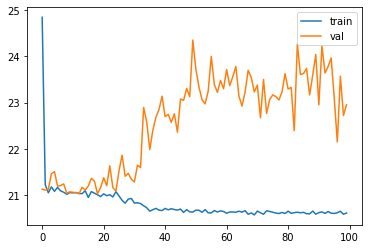

In [11]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.legend(['train', 'val'], loc='upper right')
plt.show()

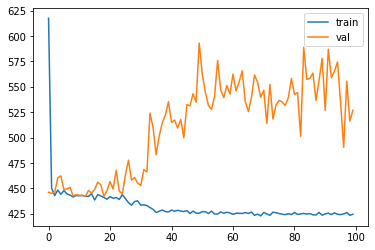

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [13]:
preds = model.predict(test_dataset)

In [14]:
submisson_df = test_df[['Id']]
submisson_df['Pawpularity'] = preds

In [15]:
submisson_df

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,28.840229
1,43a2262d7738e3d420d453815151079e,28.839809
2,4e429cead1848a298432a0acad014c9d,28.842529
3,80bc3ccafcc51b66303c2c263aa38486,28.837849
4,8f49844c382931444e68dffbe20228f4,28.840046
5,b03f7041962238a7c9d6537e22f9b017,28.838482
6,c978013571258ed6d4637f6e8cc9d6a3,28.841515
7,e0de453c1bffc20c22b072b34b54e50f,28.838799


In [16]:
submisson_df.to_csv('submission.csv', index=False)

In [17]:
model.save('/kaggle/working/transfer_images_only_model.h5')